Mean std normalisation
Early stopping

In [1]:
from torch.utils.data import Dataset,DataLoader
import torchvision as torchvision
import torch
import rasterio
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import pickle
from sklearn.metrics import f1_score

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
if torch.cuda.is_available():
    device = "cuda:0"
    print('Running on the GPU')
else:
    device = "cpu"
    print('Running on the CPU')

Running on the GPU


In [4]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1):
        super().__init__()

        self.inplanes = 64

        self.conv1 = nn.Conv2d(12, self.inplanes, kernel_size=7, stride=2, padding=3,
                            bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    

        self.layer1 = self._make_layer(block, 64, 64, layers[0])
        self.layer2 = self._make_layer(block, 64, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 256, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)
        
    def _make_layer(self,block,inplanes,planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(inplanes, planes))
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112

        x = self.layer1(x)          # 56x56
        x = self.layer2(x)          # 28x28
        x = self.layer3(x)          # 14x14
        x = self.layer4(x)          # 7x7

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # convert 1 X 1 to vector
        x = self.fc(x)
        x = torch.nn.functional.sigmoid(x)

        return x

In [5]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights="IMAGENET1K_V1")
model.fc = nn.Linear(512, 1)


In [6]:
def resnet34():
    layers=[3, 4, 6, 3]
    model = ResNet(BasicBlock, layers)
    return model

In [7]:
# for x,y in train_dataloader:
#     print(x.shape)
#     print(y.shape)
#     k = model(x.to(device))
#     break
    

In [8]:
MEAN = [0.08261849, 0.09356361, 0.1198105 , 0.13811314, 0.17161016,
       0.22894277, 0.25158173, 0.25717703, 0.26695204, 0.27032605,
       0.2368303 , 0.1811764]
STD = [0.09087279, 0.09326951, 0.09692669, 0.12191589, 0.11994482,
       0.11044275, 0.11463922, 0.11716192, 0.1178289 , 0.11643636,
       0.14539204, 0.13958859]

class satelitedata(Dataset):
    def __init__(self,imgs):

        self.imgs = imgs

        self.image_transform = torchvision.transforms.Compose([torch.from_numpy,torchvision.transforms.Normalize(mean = MEAN,std = STD,)])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self,idx):
        img = self.imgs[idx]
        target = df.loc[df["Image"]==img.split('/')[-1]]["Target"].values
        band_arr_img = rasterio.open(img).read().astype('float32')
        band_arr_img = self.image_transform(band_arr_img)
        return band_arr_img,target

In [9]:
global df

train_path = r"D:/find_mines_data/train/train/"
train_imgs = [os.path.join(train_path,i) for i in os.listdir(train_path)]
random.Random(4).shuffle(train_imgs)
train_imgs = train_imgs[0:int(len(train_imgs)*0.8)]
test_imgs = train_imgs[int(len(train_imgs)*0.8)::]

gnd_truth = r"D:\find_mines_data\train\answer.csv"
df = pd.read_csv(gnd_truth,header = None,index_col= False)
df.columns = ["Image","Target"]

X_train, X_test, y_train, y_test = train_test_split(df["Image"],df["Target"],test_size=0.5, random_state=42,stratify=df["Target"])
train_imgs = [os.path.join(train_path,i) for i in X_train.values]
test_imgs = [os.path.join(train_path,i) for i in X_test.values]



traindata = satelitedata(train_imgs)
testdata = satelitedata(test_imgs)

training_data = satelitedata(train_imgs)
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
validating_data = satelitedata(test_imgs)
valid_dataloader = DataLoader(validating_data, batch_size=8, shuffle=True)

In [10]:
def get_model():
    model = resnet34().to(device)
    loss_fn  = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr = 1e-4)
    return model,loss_fn,optimizer

def train_batch(x,y,model,optimizer,loss_fn):
    model.train()
    prediction = model(x).float()
    batch_loss = loss_fn(prediction,y.float())
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return prediction,batch_loss.item()

@torch.no_grad()
def validate_batch(x,y,model,loss_fn):
    model.eval()
    prediction = model(x).float()
    batch_loss = loss_fn(prediction,y.float())
    return prediction,batch_loss.item()
    

In [11]:
model,loss_fn,optimizer=get_model() 

epochs = 100

batch_loss_t =  []
batch_loss_v =  []

thresholds = np.arange(0.1,1,0.1)

best_threshold = 0
best_fi_score = 0

patience = 15
best_val_loss = float('inf')
counter = 0
for epoch in range(epochs):
    print("Epoch----------" + str(epoch))
    b_loss = []
    v_loss = []
    for batch in tqdm((train_dataloader),unit="batch", total=len(train_dataloader),position=0, leave=True):
        x,y = batch
        x = x.to(device)
        y = y.to(device)
        pred,loss = train_batch(x,y,model,optimizer,loss_fn)
        b_loss.append(loss)
    batch_loss_t.append(sum(b_loss)/len(b_loss))
    print(batch_loss_t[-1])
    print("Evaluating...............")
    predictions = []
    labels = []
    with torch.no_grad():
        for batch in tqdm((valid_dataloader),unit="batch", total=len(valid_dataloader),position=0, leave=True):
            x,y = batch
            x = x.to(device)
            y = y.to(device)
            pred,loss = validate_batch(x,y,model,loss_fn)
            predictions.extend(pred.cpu().numpy())
            labels.extend(y.cpu().numpy())
            v_loss.append(loss)
        batch_loss_v.append(sum(v_loss)/len(v_loss))
        print(batch_loss_v[-1])
        with open("test", "wb") as fp:
            pickle.dump([batch_loss_t[-1],batch_loss_v[-1]], fp)
        torch.save(model,"vgg16_model.pt")

        if batch_loss_v[-1] < best_val_loss:
            best_val_loss = batch_loss_v[-1]
            counter = 0
            torch.save(model,"best_model.pt")
        else:
            counter += 1

        for threshold in thresholds:


            output = (predictions > threshold).astype(int)
            f1 = f1_score(labels,output)

            if f1 > best_fi_score:
                best_fi_score = f1
                best_threshold = threshold
        

        print("best threshold is ",best_threshold)



        if counter >= patience:
            print("Early stoping activated")
            break
    



Epoch----------0


  0%|          | 0/78 [00:00<?, ?batch/s]

0.560395959382638
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.5271637199016718
best threshold is  0.2
Epoch----------1


  0%|          | 0/78 [00:00<?, ?batch/s]

0.48766962324197477
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.896842805429911
best threshold is  0.30000000000000004
Epoch----------2


  0%|          | 0/78 [00:00<?, ?batch/s]

0.48181736832245803
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.7077626730195987
best threshold is  0.30000000000000004
Epoch----------3


  0%|          | 0/78 [00:00<?, ?batch/s]

0.45828167922221696
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

1.8175756845336695
best threshold is  0.30000000000000004
Epoch----------4


  0%|          | 0/78 [00:00<?, ?batch/s]

0.47710188573751694
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.5099397851870611
best threshold is  0.30000000000000004
Epoch----------5


  0%|          | 0/78 [00:00<?, ?batch/s]

0.4431976034091069
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.5082780414093764
best threshold is  0.1
Epoch----------6


  0%|          | 0/78 [00:00<?, ?batch/s]

0.452766314913065
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.5583195361571435
best threshold is  0.1
Epoch----------7


  0%|          | 0/78 [00:00<?, ?batch/s]

0.42715489348539937
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.48672650334162587
best threshold is  0.1
Epoch----------8


  0%|          | 0/78 [00:00<?, ?batch/s]

0.42851470487240034
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.46617081809120303
best threshold is  0.1
Epoch----------9


  0%|          | 0/78 [00:00<?, ?batch/s]

0.419403911783145
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3827416935028174
best threshold is  0.4
Epoch----------10


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3860887717933227
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.42088224146610653
best threshold is  0.4
Epoch----------11


  0%|          | 0/78 [00:00<?, ?batch/s]

0.4040813724964093
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.5198576259307373
best threshold is  0.4
Epoch----------12


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3928917875656715
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.39841689957449067
best threshold is  0.2
Epoch----------13


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3915133349215373
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.44795429033155626
best threshold is  0.1
Epoch----------14


  0%|          | 0/78 [00:00<?, ?batch/s]

0.4018245520882117
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.4067935698116437
best threshold is  0.1
Epoch----------15


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3748521017722594
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.38582663374164927
best threshold is  0.1
Epoch----------16


  0%|          | 0/78 [00:00<?, ?batch/s]

0.354914553463459
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.38318105280781406
best threshold is  0.1
Epoch----------17


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3440308542205737
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3239007910283712
best threshold is  0.2
Epoch----------18


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3916241633586394
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3101799341921623
best threshold is  0.2
Epoch----------19


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3689898275412046
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.34442214257059955
best threshold is  0.2
Epoch----------20


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3462127422293027
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.31878930922502124
best threshold is  0.2
Epoch----------21


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3288640767717973
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3461675700277854
best threshold is  0.2
Epoch----------22


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3193756464200142
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3415685695094558
best threshold is  0.2
Epoch----------23


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3160272019986923
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3502000114426781
best threshold is  0.2
Epoch----------24


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3482636083395053
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.37149775930895257
best threshold is  0.2
Epoch----------25


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3266699247253247
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.32478896901011467
best threshold is  0.2
Epoch----------26


  0%|          | 0/78 [00:00<?, ?batch/s]

0.33586736395955086
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3321895758406474
best threshold is  0.2
Epoch----------27


  0%|          | 0/78 [00:00<?, ?batch/s]

0.32527349937038547
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.30156922944558734
best threshold is  0.2
Epoch----------28


  0%|          | 0/78 [00:00<?, ?batch/s]

0.30707072934661156
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3458638066091599
best threshold is  0.2
Epoch----------29


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3145653970348529
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3504600127060444
best threshold is  0.2
Epoch----------30


  0%|          | 0/78 [00:00<?, ?batch/s]

0.28635446469371134
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.2769885501370598
best threshold is  0.2
Epoch----------31


  0%|          | 0/78 [00:00<?, ?batch/s]

0.27457159666869885
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.32566163423829353
best threshold is  0.2
Epoch----------32


  0%|          | 0/78 [00:00<?, ?batch/s]

0.28996323889646775
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.28669496348653084
best threshold is  0.2
Epoch----------33


  0%|          | 0/78 [00:00<?, ?batch/s]

0.2878989037603904
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.329357951760101
best threshold is  0.2
Epoch----------34


  0%|          | 0/78 [00:00<?, ?batch/s]

0.2825936725697456
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.36331777625645584
best threshold is  0.2
Epoch----------35


  0%|          | 0/78 [00:00<?, ?batch/s]

0.28432445662717026
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3082833601734959
best threshold is  0.2
Epoch----------36


  0%|          | 0/78 [00:00<?, ?batch/s]

0.2712426391454079
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.30740412360487074
best threshold is  0.2
Epoch----------37


  0%|          | 0/78 [00:00<?, ?batch/s]

0.2742223581060385
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.34445824244847667
best threshold is  0.2
Epoch----------38


  0%|          | 0/78 [00:00<?, ?batch/s]

0.2599997781217098
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.4147417426157074
best threshold is  0.2
Epoch----------39


  0%|          | 0/78 [00:00<?, ?batch/s]

0.2591743642607561
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3527743477398195
best threshold is  0.2
Epoch----------40


  0%|          | 0/78 [00:00<?, ?batch/s]

0.21442143423243976
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.39553955865976137
best threshold is  0.2
Epoch----------41


  0%|          | 0/78 [00:00<?, ?batch/s]

0.24836894196386522
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.36112904127758855
best threshold is  0.2
Epoch----------42


  0%|          | 0/78 [00:00<?, ?batch/s]

0.2097931090169228
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3615003810383571
best threshold is  0.2
Epoch----------43


  0%|          | 0/78 [00:00<?, ?batch/s]

0.22017872725159693
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.3414513660976902
best threshold is  0.2
Epoch----------44


  0%|          | 0/78 [00:00<?, ?batch/s]

0.25078139626062834
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.6000448303321042
best threshold is  0.2
Epoch----------45


  0%|          | 0/78 [00:00<?, ?batch/s]

0.24351551832678991
Evaluating...............


  0%|          | 0/78 [00:00<?, ?batch/s]

0.30964322213847667
best threshold is  0.2
Early stoping activated


In [12]:
output

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
    

<function matplotlib.pyplot.show(close=None, block=None)>

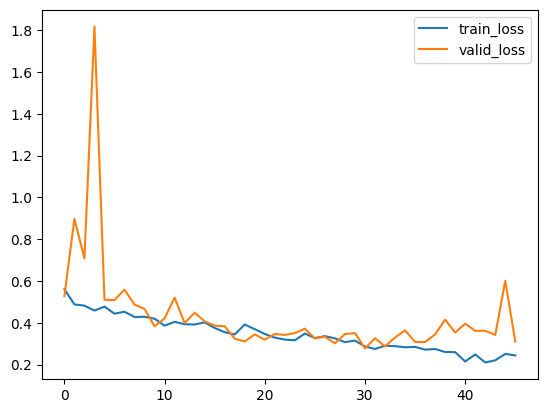

In [14]:
from matplotlib import pyplot as plt
plt.plot(batch_loss_t, label='train_loss')
plt.plot(batch_loss_v, label='valid_loss')
plt.legend()
plt.savefig("submission_loss.jpg")
plt.show

In [15]:
best_threshold

0.2

In [16]:
best_fi_score

0.75

In [ ]:
image_transform = torchvision.transforms.Compose([torch.from_numpy,torchvision.transforms.Normalize(mean = MEAN,std = STD,)])

flder_path = ""

result = pd.DataFrame()

img_column = []
pred_column = []

for img in os.listdir(flder_path):
    band_arr_img = rasterio.open(os.path.join(flder_path,img)).read().astype('float32')
    x = image_transform(band_arr_img)
    x = x.to(device)
    prediction = model(x).float()
    img_column.append(img)
    pred_column.append(prediction)

df = pd.DataFrame(list(zip(img_column,prediction)))

df.to_csv("submission.csv",index=False)
    

    
    